# Integrated Storage Autopilot

## Description

Learn the capabilities provided by the integrated storage's autopilot feature to keep a Vault cluster healthy.

## Overview

Vault 1.2 first introduced an internal storage backend, Integrated Storage, as
a _technical preview_ in addition to supported external storage types.
(Integrated Storage became generally available in Vault 1.4.) Using the
integrated storage, data gets replicated to all the nodes in the cluster using
the raft consensus protocol. The management of the nodes in the cluster was a
manual process.

Vault 1.7 introduced
[autopilot](https://www.vaultproject.io/docs/concepts/integrated-storage/autopilot)
to simplify and automate the cluster management for integrated storage. The
autopilot includes:

- Cluster node health check
- Server stabilization: prevent disruption to raft quorum due to an unstable new node
  - Monitor newly added node health for a period and decide promotion to voter status
- Dead server cleanup - periodic, automatic clean-up of failed servers

> Autopilot is enabled by default upon upgrading to Vault 1.7. Server stabilization works by default, but you need to enable the dead server
cleanup explicitly. You will learn in the [autopilot configuration](#autopilot-configuration) section.

## Prerequisites

This tutorial requires Vault, sudo access, and additional configuration to
create the cluster.

- [**Vault 1.7.0** or later](https://learn.hashicorp.com/tutorials/vault/getting-started-install)

### Set Main Environment Variables

In [ ]:
export RED="\e[0;31m" YELLOW="\e[0;33m" BLDYELLOW="\e[1;33m" GREEN="\e[0;32m"
export CYAN="\e[0;36m" BLUE="\e[0;34m" WHITE="\e[0;37m" BLDWHITE="\e[1;37m"
export NC="\e[0m"

printf "${GREEN}# Set MAIN_DIR for future reference.${NC}\n"
export MAIN_DIR=${PWD}

Be sure to replace `VAULT_ADDR` with your own values.

In [ ]:
printf "${GREEN}# Set Terraform Variables.${NC}\n"
export VAULT_ADDR="http://127.0.0.1:8200"
export VAULT_PORT=8200
# export VAULT_TOKEN=root #setting this here breaks the scripts

export GIT_REPO_DIR="config/vault/vault-guides"

printf "\n${GREEN}# Print Variables.${NC}\n"
printf "\n$MAIN_DIR \n $VAULT_ADDR \n $GIT_REPO_DIR \n"

# Some commands may have sensitive information. Prevent commands starting with a space to be saved to shell history.
HISTCONTROL=ignoreboth # do not save lines that begin with space in history

## Scenario setup

To demonstrate the Autopilot feature, you will start 6 Vault instances, each listens to a different port as shown in the diagram below.

<img src=attachment:328f4ee7-054a-4b53-a09d-441e1b6d9376.png width=50%>

| Name | Address:Port | Status | Comments |
| --- | --- | --- | --- |
|**vault_1** | (`http://127.0.0.1:8100` | initialized and unsealed | The root token creates a transit key that enables the other Vaults auto-unseal. This Vault server **is not** a part of the cluster.|
| **vault_2** | `http://127.0.0.1:8200` | initialized and unsealed | This Vault starts as the cluster **leader**. An example K/V-V2 secret is created. |
| **vault_3** | `http://127.0.0.1:8300` | unsealed | started and automatically joins the cluster via `retry_join`. |
| **vault_4** | `http://127.0.0.1:8400` | unsealed | started and automatically joins the cluster via `retry_join`. |
| **vault_5** | `http://127.0.0.1:8500` | unsealed | started and automatically joins the cluster via `retry_join`. |
| **vault_6** | `http://127.0.0.1:8600` | unsealed | started and automatically joins the cluster via `retry_join`. |

> If this is your first time setting up a Vault cluster with integrated
storage, go through the [Vault HA Cluster with Integrated
Storage](/tutorials/vault/raft-storage) tutorial.
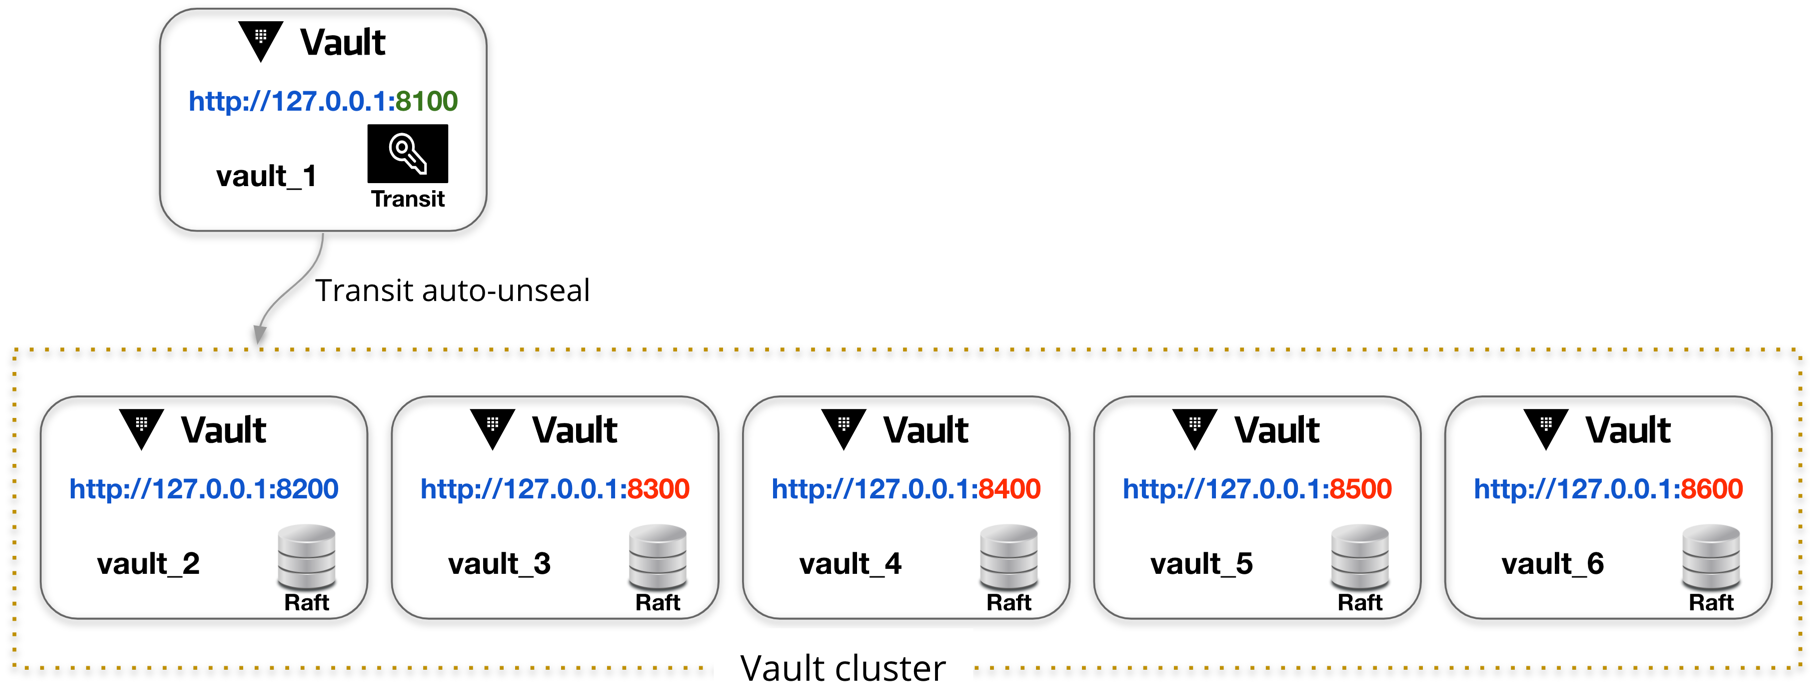

### Clone the repo

Retrieve the configuration by cloning or downloading the [`hashicorp/vault-guides`](https://github.com/hashicorp/vault-guides) repository from GitHub.

Clone the repository.

In [ ]:
git clone https://github.com/hashicorp/vault-guides.git $GIT_REPO_DIR

>   This repository contains supporting content for all of the Vault learn
   tutorials. The content specific to this tutorial can be found within a
   sub-directory.

Change the working directory to `vault-guides/operations/raft-autopilot/local`.

In [ ]:
pushd $GIT_REPO_DIR/operations/raft-autopilot/local

### Deploy Vault Cluster and Transit Auto-unseal

Execute the `run_all.sh` script to spin up a Vault cluster with 5 nodes. This takes about a minute.

In [ ]:
# Set the run-all.sh file to executable.
chmod +x run_all.sh
./run_all.sh

Sample Output

```shell
[vault_1] Creating configuration
  - creating /git/vault-guides/operations/raft-autopilot/local/config-vault_1.hcl
[vault_2] Creating configuration
  - creating /git/vault-guides/operations/raft-autopilot/local/config-vault_2.hcl
  - creating /git/vault-guides/operations/raft-autopilot/local/raft-vault_2

...snip...

[vault_5] starting Vault server @ http://127.0.0.1:8500
Using [vault_1] root token (s.5rjDMzU5Kj9bImUVaqPpihAo) to retrieve transit key for auto-unseal

[vault_6] starting Vault server @ http://127.0.0.1:8600
Using [vault_1] root token (s.5rjDMzU5Kj9bImUVaqPpihAo) to retrieve transit key for auto-unseal
```

You can find the server configuration files (`config-vault_*.hcl`) and the log files (`vault_*.log`) in the working directory.

### Verify the cluster

In [ ]:
vault operator raft list-peers

```bash
Node       Address           State       Voter
----       -------           -----       -----
vault_2    127.0.0.1:8201    leader      true
vault_3    127.0.0.1:8301    follower    true
vault_4    127.0.0.1:8401    follower    true
vault_5    127.0.0.1:8501    follower    true
vault_6    127.0.0.1:8601    follower    true
```

The `vault_2` is the leader.

## Understand the autopilot behavior

### CLI command

View the help message for the `vault operator raft autopilot` command.

```shell
 $ vault operator raft autopilot -help

 This command is accessed by using one of the subcommands below.

 Subcommands:
	 get-config    Returns the configuration of the autopilot subsystem under integrated storage
	 set-config    Modify the configuration of the autopilot subsystem under integrated storage
	 state         Displays the state of the raft cluster under integrated storage as seen by autopilot
```

#### Display cluster status

Display the current cluster status.

In [ ]:
vault operator raft autopilot state

```shell
 Healthy:                      true
 Failure Tolerance:            2
 Leader:                       vault_2
 Voters:
	vault_2
	vault_3
	vault_4
	vault_5
	vault_6
 Servers:
	vault_2
	   Name:            vault_2
	   Address:         127.0.0.1:8201
	   Status:          leader
	   Node Status:     alive
	   Healthy:         true
	   Last Contact:    0s
	   Last Term:       3
	   Last Index:      118
	vault_3
	   Name:            vault_3
	   Address:         127.0.0.1:8301
	   Status:          voter
	   Node Status:     alive
	   Healthy:         true
	   Last Contact:    1.73895338s
	   Last Term:       3
	   Last Index:      118
	vault_4
	   Name:            vault_4
	   Address:         127.0.0.1:8401
	   Status:          voter
	   Node Status:     alive
	   Healthy:         true
	   Last Contact:    4.68575147s
	   Last Term:       3
	   Last Index:      118
	vault_5
	   Name:            vault_5
	   Address:         127.0.0.1:8501
	   Status:          voter
	   Node Status:     alive
	   Healthy:         true
	   Last Contact:    2.630693989s
	   Last Term:       3
	   Last Index:      118
	vault_6
	   Name:            vault_6
	   Address:         127.0.0.1:8601
	   Status:          voter
	   Node Status:     alive
	   Healthy:         true
	   Last Contact:    579.174724ms
	   Last Term:       3
	   Last Index:      118
```

### API call using cURL

> **NOTE:** The root token of `vault_2` is stored in `root_token-vault_2` file.

#### Display the current cluster status

Use the root token to display the current cluster status.

In [ ]:
curl -s -H "X-Vault-Token: $(cat root_token-vault_2)" \
    http://127.0.0.1:8200/v1/sys/storage/raft/autopilot/state | jq .data

**NOTE:** This example uses [jq](https://stedolan.github.io/jq/download/) to process the JSON output for readability.

**Example output:**
<details><summary></summary>

 ```plaintext
 {
   "failure_tolerance": 2,
   "healthy": true,
   "leader": "vault_2",
   "non_voters": null,
   "servers": {
	 "vault_2": {
	   "id": "vault_2",
	   "name": "vault_2",
	   "address": "127.0.0.1:8201",
	   "node_status": "alive",
	   "last_contact": "0s",
	   "last_term": 3,
	   "last_index": 55,
	   "healthy": true,
	   "stable_since": "2021-03-22T10:41:08.141954-07:00",
	   "status": "leader",
	   "meta": null
	 },
	 "vault_3": {
	   "id": "vault_3",
	   "name": "vault_3",
	   "address": "127.0.0.1:8301",
	   "node_status": "alive",
	   "last_contact": "1.917119745s",
	   "last_term": 3,
	   "last_index": 55,
	   "healthy": true,
	   "stable_since": "2021-03-22T10:41:26.143207-07:00",
	   "status": "voter",
	   "meta": null
	 },
	 "vault_4": {
	   "id": "vault_4",
	   "name": "vault_4",
	   "address": "127.0.0.1:8401",
	   "node_status": "alive",
	   "last_contact": "4.874691708s",
	   "last_term": 3,
	   "last_index": 55,
	   "healthy": true,
	   "stable_since": "2021-03-22T10:41:28.143872-07:00",
	   "status": "voter",
	   "meta": null
	 },
	 "vault_5": {
	   "id": "vault_5",
	   "name": "vault_5",
	   "address": "127.0.0.1:8501",
	   "node_status": "alive",
	   "last_contact": "2.83318126s",
	   "last_term": 3,
	   "last_index": 55,
	   "healthy": true,
	   "stable_since": "2021-03-22T10:41:30.143251-07:00",
	   "status": "voter",
	   "meta": null
	 },
	 "vault_6": {
	   "id": "vault_6",
	   "name": "vault_6",
	   "address": "127.0.0.1:8601",
	   "node_status": "alive",
	   "last_contact": "808.191653ms",
	   "last_term": 3,
	   "last_index": 55,
	   "healthy": true,
	   "stable_since": "2021-03-22T10:41:32.146552-07:00",
	   "status": "voter",
	   "meta": null
	 }
   },
   "voters": [
	 "vault_2",
	 "vault_3",
	 "vault_4",
	 "vault_5",
	 "vault_6"
   ]
 }
 ```
</details>

This displays the overall health of the cluster, and its failure tolerance.
The current leader node is `vault_2`. The **Failure Tolerance** is `2`;
therefore, you can lose up to 2 nodes and still maintain the quorum. The
**healthy** parameter value is `true` for all nodes in the cluster.

> Refer to the [deployment
table](https://www.vaultproject.io/docs/internals/integrated-storage#deployment-table)
for the quorum size and failure tolerance for various cluster sizes.

### Stop one of the nodes

Stop `vault_6`.

In [ ]:
# Set the cluster.sh file to executable.
chmod +x cluster.sh

./cluster.sh stop vault_6

```shell
./cluster.sh stop vault_6


Found 1 Vault service(s) matching that name
[vault_6] stopping
```

**_Optional:_** You can verify that `vault_6` is not running.

In [ ]:
ps | grep vault

```shell-session
$ ps | grep vault

41873 ttys009    0:34.57 vault server -log-level=trace -config <path>/config-vault_1.hcl
41919 ttys009   11:07.38 vault server -log-level=trace -config <path>/config-vault_2.hcl
41966 ttys009    1:50.94 vault server -log-level=trace -config <path>/config-vault_3.hcl
41982 ttys009    1:52.26 vault server -log-level=trace -config <path>/config-vault_4.hcl
41998 ttys009    1:50.86 vault server -log-level=trace -config <path>/config-vault_5.hcl
45834 ttys009    0:00.01 grep --color=auto --exclude-dir=.bzr --exclude-dir=CVS --exclude-dir=.git --exclude-dir=.hg --exclude-dir=.svn --exclude-dir=.idea --exclude-dir=.tox vault
```

### Check cluster health

Check the cluster health.

In [ ]:
vault operator raft autopilot state

NOTE: The **Healthy** parameter value is `false` on the cluster, and the **Failure Tolerance** is `1`. 

 ```shell
 Healthy:                      false
 Failure Tolerance:            1
 Leader:                       vault_2
 Voters:
	vault_2
	vault_3
	vault_4
	vault_5
	vault_6
 ...snip...
 ```

The **Healthy** state of the `vault_6` is
   `false`; therefore, you know which node failed.

 ```plaintext
 ...snip...
	vault_6
	   Name:            vault_6
	   Address:         127.0.0.1:8601
	   Status:          voter
	   Node Status:     alive
	   Healthy:         false
	   Last Contact:    55.577082309s
	   Last Term:       3
	   Last Index:      154
 ```

> Although `vault_6` is no longer running, it is still a cluster member at this point.

## Autopilot configuration

Check the autopilot settings to see the default behavior.

| Parameter | Demo Settings | Comment | Description |
| --------- | :-----------: | --- | ----------- |
| Cleanup Dead Servers (`bool: false`) | `true` | | Specifies automatic removal of dead server nodes periodically. |
| Dead Server Last Contact Threshold (`string: "24h"`) | `60s` | Determine what threshold works best for you | Limit the amount of time a server can go without leader contact before being considered failed. |
| Min Quorum (`int: 0`) | `3` | Quorum is (N+1)/2. ex if you have 5 nodes, don't clean up nodes unless you have a min of 3 | Minimum number of servers allowed in ca cluster before autopilot can prune dead servers. |
| Last Contact Threshold (`string: "10s"`) | default | | Limit the amount of time a server can go without leader contact before being considered unhealthy. |
| Server Stabilization Time (`string: "10s"`) | `30s` | Defaults are fine. Use 30s to observe changes in demo | Minimum amount of time a server must be stable in the 'healthy' state before being added to the cluster. |
| Max Trailing Logs (`int: 1000`) | default | | Maximum number of log entries in the Raft log that a server can be behind its leader before being considered unhealthy. |

### CLI command

#### Check the autopilot configuration

Check the current autopilot configuration.

In [ ]:
vault operator raft autopilot get-config

```shell
Key                                   Value
---                                   -----
Cleanup Dead Servers                  false
Last Contact Threshold                10s
Dead Server Last Contact Threshold    24h0m0s
Server Stabilization Time             10s
Min Quorum                            0
Max Trailing Logs                     1000
```

**NOTE:** The **Cleanup Dead Servers** parameter defaults to `false`.

#### Update autopilot configuration

Update the autopilot configuration to enable the dead server cleanup. For demonstration:
* Set the **Dead Server Last Contact Threshold** to 60 seconds,
* Set the **Server Stabilization Time** to 30 seconds.

First, create the request payload.

In [ ]:
vault operator raft autopilot set-config \
  -cleanup-dead-servers=true \
  -dead-server-last-contact-threshold=60s \
  -server-stabilization-time=30s \
  -min-quorum=3

#### Verify autopilot configuration

Verify the configuration.

In [ ]:
vault operator raft autopilot get-config

```shell
Key                                   Value
---                                   -----
Cleanup Dead Servers                  true
Last Contact Threshold                10s
Dead Server Last Contact Threshold    60s
Server Stabilization Time             15s
Min Quorum                            3
Max Trailing Logs                     1000
```

#### Check cluster health

Check the cluster health.

In [ ]:
vault operator raft autopilot state

```shell
Healthy:                      true
Failure Tolerance:            1
Leader:                       vault_2
Voters:
  vault_2
  vault_3
  vault_4
  vault_5
Servers:
  ...snip...
```

* The cluster's **Healthy** parameter value is back to `true`.
* Notice that `vault_6` is no longer listed.
* The **Voters** parameter lists `vault_2`
through `vault_5`.

Check the cluster peers to double-check.

In [ ]:
vault operator raft list-peers

```shell
Node       Address           State       Voter
----       -------           -----       -----
vault_2    127.0.0.1:8201    leader      true
vault_3    127.0.0.1:8301    follower    true
vault_4    127.0.0.1:8401    follower    true
vault_5    127.0.0.1:8501    follower    true
```

### API call using cURL

#### Check the autopilot configuration - API

Check the current autopilot configuration.

In [ ]:
curl --header "X-Vault-Token: $(cat root_token-vault_2)" \
   http://127.0.0.1:8200/v1/sys/storage/raft/autopilot/configuration | jq .data

**Output:**

```json
{
	"cleanup_dead_servers": false,
	"dead_server_last_contact_threshold": "24h0m0s",
	"last_contact_threshold": "10s",
	"max_trailing_logs": 1000,
	"min_quorum": 0,
	"server_stabilization_time": "10s"
}
```

The `cleanup_dead_servers` parameter is set to `false`.

#### Update autopilot configuration - API

Update the autopilot configuration to enable the dead server cleanup. For demonstration:
* Set the **Dead Server Last Contact Threshold** to 60 seconds,
* Set the **Server Stabilization Time** to 30 seconds.

First, create the request payload.

In [ ]:
tee payload.json << EOF
{
  "cleanup_dead_servers": true,
  "dead_server_last_contact_threshold":"60s",
  "min_quorum":"3",
  "server_stabilization_time": "30s"
}
EOF

Update the autopilot configuration.

In [ ]:
curl --header "X-Vault-Token: $(cat root_token-vault_2)" \
   --request POST \
   --data @payload.json \
   http://127.0.0.1:8200/v1/sys/storage/raft/autopilot/configuration

#### Verify autopilot configuration - API

Verify the configuration.

In [ ]:
curl --header "X-Vault-Token: $(cat root_token-vault_2)" \
    http://127.0.0.1:8200/v1/sys/storage/raft/autopilot/configuration | jq .data

**Output:**

```json
{
  "cleanup_dead_servers": true,
  "dead_server_last_contact_threshold": "60s",
  "last_contact_threshold": "10s",
  "max_trailing_logs": 1000,
  "min_quorum": 3,
  "server_stabilization_time": "30s"
}
```

#### Check cluster health - API

Check the cluster health.

In [ ]:
curl --header "X-Vault-Token: $(cat root_token-vault_2)" \
    http://127.0.0.1:8200/v1/sys/storage/raft/autopilot/state | jq .data

**Output:**

```json
{
	"failure_tolerance": 1,
	"healthy": true,
	"leader": "vault_2",
	"non_voters": null,
	"servers": {
	  ...snip...
 },
	"voters": [
	   "vault_2",
	   "vault_3",
	   "vault_4",
	   "vault_5"
	]
}
```


The cluster's **healthy** parameter value is back to `true`. Notice that
`vault_6` is no longer listed. The `voters` parameter lists `vault_2`
through `vault_5`.

## Verification

### Add a new node to the cluster

Explore how the autopilot configuration settings influence the cluster when you
add a new node.

Add a new node (`vault_7`) to the cluster.

In [ ]:
./cluster.sh setup vault_7

**Output**

```shell
[vault_7] starting Vault server @ http://127.0.0.1:8700
Using [vault_1] root token (s.wsEIMfqTipb0mZT051TNbcYJ) to retrieve transit key for auto-unseal
```

In [ ]:
vault operator raft list-peers

#### Check cluster health

Check the cluster health.

In [ ]:
vault operator raft autopilot state

**Output**
```shell
Healthy:                      true
Failure Tolerance:            1
Leader:                       vault_2
Voters:
  vault_2
  vault_3
  vault_4
  vault_5
Servers:

  ...snip...

  vault_7
	 Name:            vault_7
	 Address:         127.0.0.1:8701
	 Status:          non-voter
	 Node Status:     alive
	 Healthy:         true
	 Last Contact:    2.580581282s
	 Last Term:       3
	 Last Index:      78
```

The `vault_7` server joins the cluster as a non-voter until the **Server Stabilization Time** of 30 seconds elapses.

Wait for 30 seconds and check the cluster peers.

```shell
$ vault operator raft list-peers

Node       Address           State       Voter
----       -------           -----       -----
vault_2    127.0.0.1:8201    leader      true
vault_3    127.0.0.1:8301    follower    true
vault_4    127.0.0.1:8401    follower    true
vault_5    127.0.0.1:8501    follower    true
vault_7    127.0.0.1:8701    follower    true
```

Now, the `vault_7` server should be a voter. This is a part of the server stabilization mechanism of the autopilot.

> **Vault Enterprise:** The explicit [**non-voter**
nodes](/tutorials/vault/performance-standbys#integrated-storage) behave the
same way as before and remain non-voters as designed. If the dead server
cleanup is enabled, it will prune failed non-voters.

In [ ]:
vault operator raft list-peers

### Configure the state check interval

By default, the autopilot picks up any state change at an interval of 10 seconds.
To change the default, set the `autopilot_reconcile_interval` parameter inside
the `storage` stanza in the server configuration file.

**Example:** The following server configuration file sets the autopilot to picks
up state change an interval of 15 seconds.

```go
storage "raft" {
  path = "/path/to/raft/data"
  node_id = "raft_node_1"

  # overwrite the default interval
  autopilot_reconcile_interval = "15"
}

listener "tcp" {
  address     = "127.0.0.1:8200"
  tls_disable = true
}

cluster_addr = "http://127.0.0.1:8201"
```

### Add `vault_6` as a new node

To add a node back after it has already been removed, I delete it's storage backend and start it up.

In [ ]:
./cluster.sh stop vault_6
rm -rf raft-vault_6
mkdir -p raft-vault_6
./cluster.sh start vault_6

#### Check cluster health

In [ ]:
vault operator raft autopilot state

```shell
Healthy:                      true
Failure Tolerance:            2
Leader:                       vault_2
Voters:
  vault_2
  vault_3
  vault_4
  vault_5
Servers:
  ...snip...
```

The cluster's **Healthy** parameter value is `true`. Notice that `vault_6` is listed. The **Voters** parameter lists `vault_2`
through `vault_7` and `vault_6`.

Check the cluster peers to double-check.

In [ ]:
vault operator raft list-peers

```shell
Node       Address           State       Voter
----       -------           -----       -----
vault_2    127.0.0.1:8201    leader      true
vault_3    127.0.0.1:8301    follower    true
vault_4    127.0.0.1:8401    follower    true
vault_5    127.0.0.1:8501    follower    true
vault_7    127.0.0.1:8701    follower    true
vault_6    127.0.0.1:8601    follower    true
```

### Add vault_6 as an existing node

If I want to stop a pod temporarily and then add it back, I only have a short window (`60s`). This is useful in case I don't want to destroy the storage backend.

In [ ]:
./cluster.sh stop vault_6

Confirm that `vault_6` is still part of the cluster but it's `Healthy` parameter is `false`.

In [ ]:
vault operator raft autopilot state

```
Healthy:                      false
Failure Tolerance:            1
Leader:                       vault_2
Voters:
   vault_2
   vault_3
   vault_4
   vault_5
   vault_7
   vault_6
...
   vault_6
      Name:            vault_6
      Address:         127.0.0.1:8601
      Status:          voter
      Node Status:     alive
      Healthy:         false
...
```

Start `vault_6` back up within the 60 seconds.

In [ ]:
./cluster.sh start vault_6

List the cluster members.

In [ ]:
vault operator raft list-peers

```shell
Node       Address           State       Voter
----       -------           -----       -----
vault_2    127.0.0.1:8201    leader      true
vault_3    127.0.0.1:8301    follower    true
vault_4    127.0.0.1:8401    follower    true
vault_5    127.0.0.1:8501    follower    true
vault_7    127.0.0.1:8701    follower    true
vault_6    127.0.0.1:8601    follower    false
```

NOTE: `vault_6` server might be listed as a non-voter. (The **Voter** parameter value is `false`.)

## Clean up

### Remove services, configuration, and modifications

The `cluster.sh` script provides a `clean` operation that removes all services, configuration, and modifications to your local system.

Clean up your local workstation.

In [ ]:
./cluster.sh clean

```shell
Found 1 Vault service(s) matching that name
[vault_1] stopping

...snip...

Removing log file /git/vault-guides/operations/raft-autopilot/local/vault_5.log
Removing log file /git/vault-guides/operations/raft-autopilot/local/vault_6.log
Clean complete
```

### Remove file artifacts

In [ ]:
rm -rf $GIT_REPO_DIR

## Help and reference

- [Integrated Storage Internal documentation](https://www.vaultproject.io/docs/internals/integrated-storage)
- [Integrated Storage Concepts documentation](https://www.vaultproject.io/docs/concepts/integrated-storage/autopilot)
- [Commands (CLI) - operator raft autopilot](https://www.vaultproject.io/docs/commands/operator/raft#autopilot)
- [API docs - sys/storage/raft/autopilot](https://www.vaultproject.io/api-docs/system/storage/raftautopilot)
- [Vault HA Cluster with Integrated Storage](https://learn.hashicorp.com/tutorials/vault/raft-storage) tutorial
- [Preflight Checklist - Migrating to Integrated Storage](/tutorials/vault/storage-migration-checklist)
- [Vault with Integrated Storage Reference Architecture](https://learn.hashicorp.com/tutorials/vault/raft-reference-architecture?in=vault/raft)

### Vault Enterprise Replication 

If you are running Vault Enterprise with replication enabled, read the
[Replication
section](https://www.vaultproject.io/docs/concepts/integrated-storage/autopilot#replication)
in the Autopilot documentation for additional information. 

The following tutorials walk through the Enterprise Replication setup:
   
- [Disaster Recovery Replication Setup](/tutorials/vault/disaster-recovery)
- [Performance Replication with Paths Filter](/tutorials/vault/paths-filter)